## Imports

In [1]:
from pathlib import Path
import pandas as pd
import json
import nibabel as nib
import numpy as np

from src.database import *
from src.nist import get_reference_NIST_values
from src.tools import calc_error

import matplotlib.pyplot as plt
plt.style.use('custom_matplotlibrc')
plt.rcParams["figure.figsize"] = (10,10)
fig_id = 0

## Configurations

In [2]:
database_path = Path('databases/3T_NIST_T1maps_database.pkl')
output_folder = Path("plots/04_alldatasets_scatter_NIST/")

## Define functions

In [3]:
def plot_single_scatter(x, y, y_std,
                        title, x_label, y_label,
                        file_prefix, folder_path, fig_id,
                        y_type='linear'):
    if y_type is 'linear':
        plt.errorbar(x,y, y_std, fmt='o', solid_capstyle='projecting', capsize=5)
        ax = plt.gca()
        ax.axline((1, 1), slope=1, linestyle='dashed')
        ax.set_ylim(ymin=0)
        ax.set_xlim(xmin=0)
    if y_type is 'log':
        plt.loglog(x,y,'o')
        ax = plt.gca()
        ax.set_ylim(ymin=20)
        ax.set_xlim(xmin=20)
    if y_type is 'error_t1':
        plt.errorbar(x,calc_error(x,y), fmt='o', solid_capstyle='projecting', capsize=5)
        ax = plt.gca()
        ax.axline((1, 0), slope=0, color='k')
        ax.axline((1, -10), slope=0, linestyle='dashed', color='k')
        ax.axline((1, 10), slope=0, linestyle='dashed', color='k')
    
    plt.title(title, fontsize=30)
    plt.xlabel(x_label, fontsize=26)
    plt.ylabel(y_label, fontsize=26)

    fig = plt.gcf()
    

    folder_path.mkdir(parents=True, exist_ok=True)

    if fig_id<10:
        filename = "0" + str(fig_id) + "_" + file_prefix
    else:
        filename = str(fig_id) + "_" + file_prefix

    fig.savefig(folder_path / (str(filename) + '.svg'), facecolor='white')
    fig.savefig(folder_path / (str(filename) + '.png'), facecolor='white')
    fig_id = fig_id + 1
    plt.show()
    return fig_id

## Load database

In [4]:
df = pd.read_pickle(database_path)

## Initialize variables, store mean and standard deviations of T1 in the ROIs

In [5]:
dataset_mean = np.zeros((1,14))
dataset_std = np.zeros((1,14))
version = np.array([])
ref_values = np.zeros((1,14))


ii=0
for index, row in df.iterrows():
    if type(df.loc[index]['T1 - NIST sphere 1']) is np.ndarray:

        version = np.append(version,df.loc[index]['phantom serial number'])
        if version[ii] is None:
            version[ii] = 999 # Missing version, only known case is one where we have version > 42 right now.

        if ii==0:
            ref_values = get_reference_NIST_values(version[ii])
        else:
            ref_values = np.vstack((ref_values, get_reference_NIST_values(version[ii])))
        
        tmp_dataset_mean = np.array([])
        tmp_dataset_std = np.array([])

        tmp_dataset_mean = np.append(tmp_dataset_mean, np.mean(df.loc[index]['T1 - NIST sphere 1']))
        tmp_dataset_mean = np.append(tmp_dataset_mean, np.mean(df.loc[index]['T1 - NIST sphere 2']))
        tmp_dataset_mean = np.append(tmp_dataset_mean, np.mean(df.loc[index]['T1 - NIST sphere 3']))
        tmp_dataset_mean = np.append(tmp_dataset_mean, np.mean(df.loc[index]['T1 - NIST sphere 4']))
        tmp_dataset_mean = np.append(tmp_dataset_mean, np.mean(df.loc[index]['T1 - NIST sphere 5']))
        tmp_dataset_mean = np.append(tmp_dataset_mean, np.mean(df.loc[index]['T1 - NIST sphere 6']))
        tmp_dataset_mean = np.append(tmp_dataset_mean, np.mean(df.loc[index]['T1 - NIST sphere 7']))
        tmp_dataset_mean = np.append(tmp_dataset_mean, np.mean(df.loc[index]['T1 - NIST sphere 8']))
        tmp_dataset_mean = np.append(tmp_dataset_mean, np.mean(df.loc[index]['T1 - NIST sphere 9']))
        tmp_dataset_mean = np.append(tmp_dataset_mean, np.mean(df.loc[index]['T1 - NIST sphere 10']))
        tmp_dataset_mean = np.append(tmp_dataset_mean, np.mean(df.loc[index]['T1 - NIST sphere 11']))
        tmp_dataset_mean = np.append(tmp_dataset_mean, np.mean(df.loc[index]['T1 - NIST sphere 12']))
        tmp_dataset_mean = np.append(tmp_dataset_mean, np.mean(df.loc[index]['T1 - NIST sphere 13']))
        tmp_dataset_mean = np.append(tmp_dataset_mean, np.mean(df.loc[index]['T1 - NIST sphere 14']))

        tmp_dataset_std = np.append(tmp_dataset_std, np.std(df.loc[index]['T1 - NIST sphere 1']))
        tmp_dataset_std = np.append(tmp_dataset_std, np.std(df.loc[index]['T1 - NIST sphere 2']))
        tmp_dataset_std = np.append(tmp_dataset_std, np.std(df.loc[index]['T1 - NIST sphere 3']))
        tmp_dataset_std = np.append(tmp_dataset_std, np.std(df.loc[index]['T1 - NIST sphere 4']))
        tmp_dataset_std = np.append(tmp_dataset_std, np.std(df.loc[index]['T1 - NIST sphere 5']))
        tmp_dataset_std = np.append(tmp_dataset_std, np.std(df.loc[index]['T1 - NIST sphere 6']))
        tmp_dataset_std = np.append(tmp_dataset_std, np.std(df.loc[index]['T1 - NIST sphere 7']))
        tmp_dataset_std = np.append(tmp_dataset_std, np.std(df.loc[index]['T1 - NIST sphere 8']))
        tmp_dataset_std = np.append(tmp_dataset_std, np.std(df.loc[index]['T1 - NIST sphere 9']))
        tmp_dataset_std = np.append(tmp_dataset_std, np.std(df.loc[index]['T1 - NIST sphere 10']))
        tmp_dataset_std = np.append(tmp_dataset_std, np.std(df.loc[index]['T1 - NIST sphere 11']))
        tmp_dataset_std = np.append(tmp_dataset_std, np.std(df.loc[index]['T1 - NIST sphere 12']))
        tmp_dataset_std = np.append(tmp_dataset_std, np.std(df.loc[index]['T1 - NIST sphere 13']))
        tmp_dataset_std = np.append(tmp_dataset_std, np.std(df.loc[index]['T1 - NIST sphere 14']))

        if ii==0:
            dataset_std = tmp_dataset_std
            dataset_mean = tmp_dataset_mean  
        else:
            dataset_std = np.vstack((dataset_std, tmp_dataset_std))
            dataset_mean = np.vstack((dataset_mean, tmp_dataset_mean))

        ii=ii+1


## Setup for plots

In [6]:
fig_id = 0
dims=ref_values.shape
file_prefix = 'alldatasets'

## Plot figures

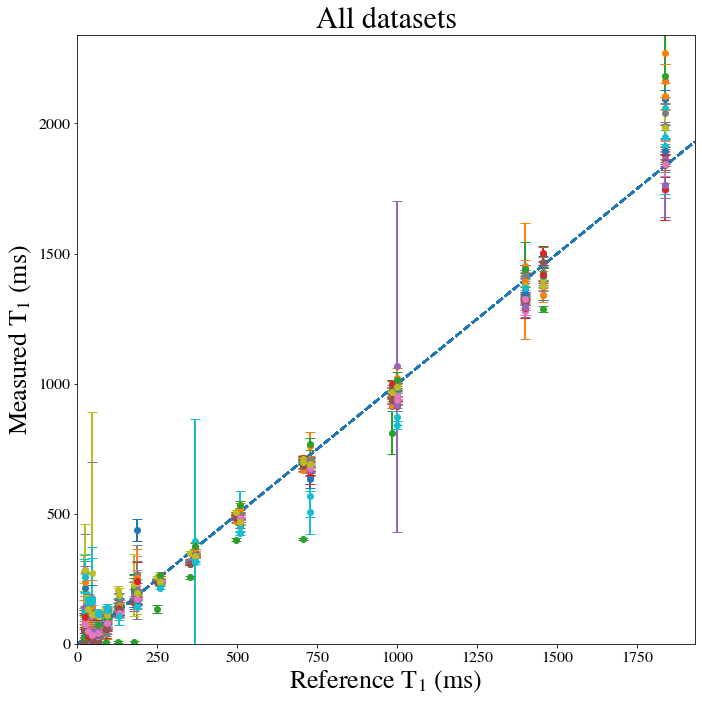

In [7]:
y_type = 'linear'
title = 'All datasets'


for ii in range(dims[0]):
    
    x=ref_values[ii,:]
    y=dataset_mean[ii,:]
    y_std=dataset_std[ii,:]
    x_label='Reference T$_1$ (ms)'
    y_label="Measured T$_1$ (ms)"
    folder_path=output_folder

    if y_type is 'linear':
        plt.errorbar(x,y, y_std, fmt='o', solid_capstyle='projecting', capsize=5)
        ax = plt.gca()
        ax.axline((1, 1), slope=1, linestyle='dashed')
        ax.set_ylim(ymin=0)
        ax.set_xlim(xmin=0)
    if y_type is 'log':
        plt.loglog(x,y,'o')
        ax = plt.gca()
        ax.set_ylim(ymin=20)
        ax.set_xlim(xmin=20)
    if y_type is 'error_t1':
        plt.errorbar(x,calc_error(x,y), fmt='o', solid_capstyle='projecting', capsize=5)
        ax = plt.gca()
        ax.axline((1, 0), slope=0, color='k')
        ax.axline((1, -10), slope=0, linestyle='dashed', color='k')
        ax.axline((1, 10), slope=0, linestyle='dashed', color='k')
    
    plt.xlabel(x_label, fontsize=26)
    plt.ylabel(y_label, fontsize=26)

plt.title(title, fontsize=30)
fig = plt.gcf()
    

folder_path.mkdir(parents=True, exist_ok=True)


if fig_id<10:
    filename = "0" + str(fig_id) + "_" + file_prefix
else:
    filename = str(fig_id) + "_" + file_prefix

fig.savefig(folder_path / (str(filename) + '.svg'), facecolor='white')
fig.savefig(folder_path / (str(filename) + '.png'), facecolor='white')
fig_id = fig_id + 1

plt.show()

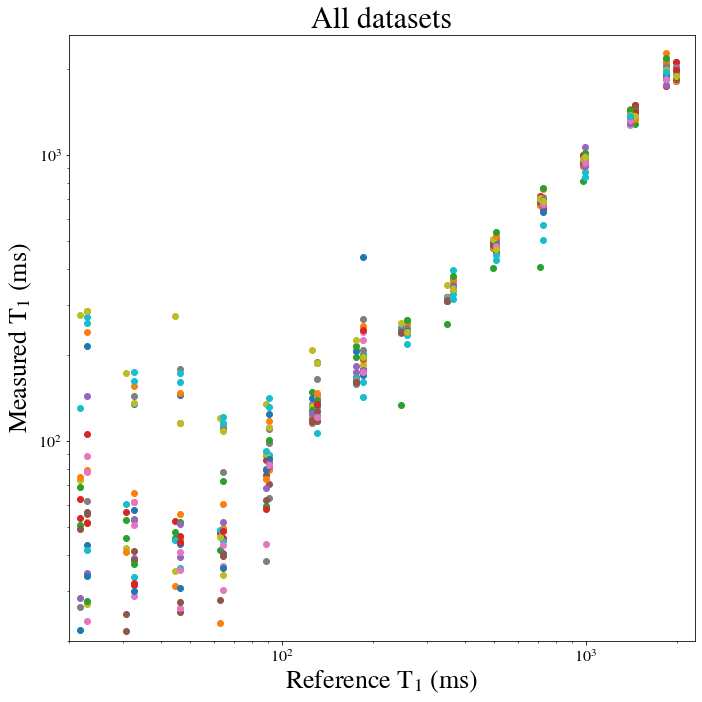

In [8]:
y_type = 'log'
title = 'All datasets'

for ii in range(dims[0]):
    
    x=ref_values[ii,:]
    y=dataset_mean[ii,:]
    y_std=dataset_std[ii,:]
    x_label='Reference T$_1$ (ms)'
    y_label="Measured T$_1$ (ms)"
    folder_path=output_folder

    if y_type is 'linear':
        plt.errorbar(x,y, y_std, fmt='o', solid_capstyle='projecting', capsize=5)
        ax = plt.gca()
        ax.axline((1, 1), slope=1, linestyle='dashed')
        ax.set_ylim(ymin=0)
        ax.set_xlim(xmin=0)
    if y_type is 'log':
        plt.loglog(x,y,'o')
        ax = plt.gca()
        ax.set_ylim(ymin=20)
        ax.set_xlim(xmin=20)
    if y_type is 'error_t1':
        plt.errorbar(x,calc_error(x,y), fmt='o', solid_capstyle='projecting', capsize=5)
        ax = plt.gca()
        ax.axline((1, 0), slope=0, color='k')
        ax.axline((1, -10), slope=0, linestyle='dashed', color='k')
        ax.axline((1, 10), slope=0, linestyle='dashed', color='k')
    
    plt.xlabel(x_label, fontsize=26)
    plt.ylabel(y_label, fontsize=26)

plt.title(title, fontsize=30)
fig = plt.gcf()
    

folder_path.mkdir(parents=True, exist_ok=True)


if fig_id<10:
    filename = "0" + str(fig_id) + "_" + file_prefix
else:
    filename = str(fig_id) + "_" + file_prefix

fig.savefig(folder_path / (str(filename) + '.svg'), facecolor='white')
fig.savefig(folder_path / (str(filename) + '.png'), facecolor='white')
fig_id = fig_id + 1
plt.show()

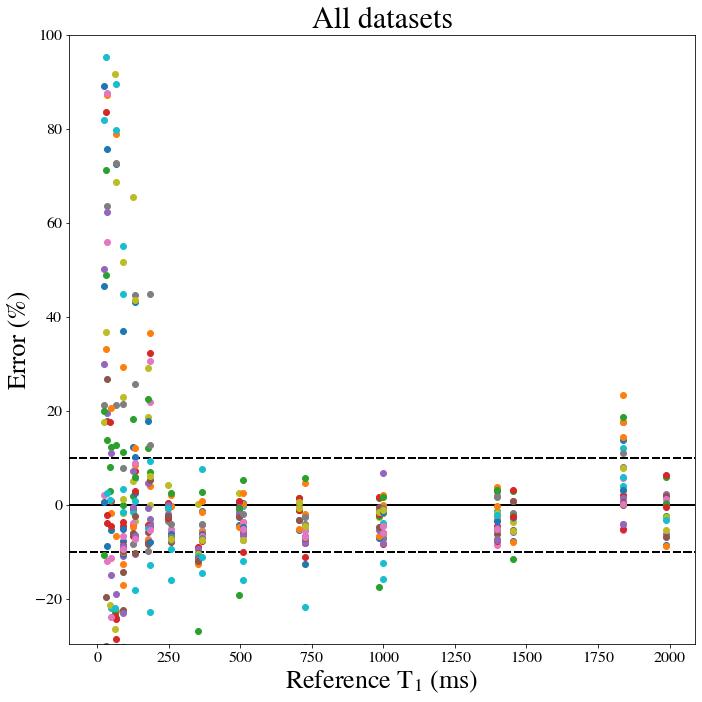

In [9]:
y_type = 'error_t1'
title = 'All datasets'

for ii in range(dims[0]):
    
    x=ref_values[ii,:]
    y=dataset_mean[ii,:]
    y_std=dataset_std[ii,:]
    x_label='Reference T$_1$ (ms)'
    y_label="Error (%)"
    folder_path=output_folder

    if y_type is 'linear':
        plt.errorbar(x,y, y_std, fmt='o', solid_capstyle='projecting', capsize=5)
        ax = plt.gca()
        ax.axline((1, 1), slope=1, linestyle='dashed')
        ax.set_ylim(ymin=0)
        ax.set_xlim(xmin=0)
    if y_type is 'log':
        plt.loglog(x,y,'o')
        ax = plt.gca()
        ax.set_ylim(ymin=20)
        ax.set_xlim(xmin=20)
    if y_type is 'error_t1':
        plt.errorbar(x,calc_error(x,y), fmt='o', solid_capstyle='projecting', capsize=5)
        ax = plt.gca()
        ax.axline((1, 0), slope=0, color='k')
        ax.axline((1, -10), slope=0, linestyle='dashed', color='k')
        ax.axline((1, 10), slope=0, linestyle='dashed', color='k')
    
    plt.xlabel(x_label, fontsize=26)
    plt.ylabel(y_label, fontsize=26)
    plt.ylim(top=100)

plt.title(title, fontsize=30)
fig = plt.gcf()
    

folder_path.mkdir(parents=True, exist_ok=True)


if fig_id<10:
    filename = "0" + str(fig_id) + "_" + file_prefix
else:
    filename = str(fig_id) + "_" + file_prefix

fig.savefig(folder_path / (str(filename) + '.svg'), facecolor='white')
fig.savefig(folder_path / (str(filename) + '.png'), facecolor='white')
fig_id = fig_id + 1
plt.show()